provenance des donnees : https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e/dataset/4

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from PIL import Image

/Users/mamoudousdiani/miniconda3/envs/car_ocr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Exploration and Gestion

In [7]:
path = "../../../DATA/License_Plate_Recognition2/"

train_filenames = [name for name in os.listdir(path + "train/images/")]
test_filenames = [name for name in os.listdir(path + "test/images/")]
validation_filenames = [name for name in os.listdir(path+ "valid/images/")]

NameError: name 'os' is not defined

In [14]:
len (train_filenames), len (test_filenames), len (validation_filenames)

(10501, 510, 1023)

In [15]:
#filenames = train_filenames/validation_filenames/test_filenames
#img_dir = path+"/train/images/" / path+"/valid/images/" / path+"/test/images/"
#label_dir = path+"/train/labels/" / path+"/valid/labels/" / path+"/test/labels/"

def recup_coordonnee (path):
    f = open(path)
    contenu = f.read()
    f.close()
    return contenu.split('\n')

def prep_data (coor):
    data=[]
    for i in range (len(coor)):
        d=coor[i].split(' ')
        for j in range (len(d)):
            d[j] = (float(d[j]))
        data.append(d)
    return data

def recup_boxe (path):
    coor = recup_coordonnee (path)
    coor = prep_data (coor)
    if coor:
        return torch.tensor(coor, dtype=torch.float32)
    else:
        # Retourne un tensor 0x4 (0 boîtes, 4 coordonnées)
        return torch.empty(0, 4, dtype=torch.float32)

class CustomImageDataset(Dataset):
    def __init__(self, filenames, img_dir, label_dir, transform=None):
        self.img_labels = filenames
        self.img_dir = img_dir
        self.label_dir = label_dir
        if transform is None:
            self.transform = self.default_transform
        else:
            self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = read_image(img_path)
        label_path = os.path.join(self.label_dir, self.img_labels[idx][:-3] + 'txt')
        label = recup_boxe(label_path)
        image = self.transform(image)
        return image, label
    
    def default_transform(self, image_tensor):
        return image_tensor.float() / 255.0

In [16]:
def custom_collate_fn(batch):
    # 'batch' est une liste de tuples: [(image_1, targets_1), (image_2, targets_2), ...]
    
    # 1. Empiler les images (elles sont supposées avoir été redimensionnées/paddées)
    images = [item[0] for item in batch]
    images = torch.stack(images, 0) # Ceci crée un tenseur de taille [batch_size, C, H, W]
    
    # 2. Conserver les cibles comme une LISTE de tenseurs
    targets = [item[1] for item in batch] # Les targets_i sont des tenseurs de taille [Nombre_Objets_i, 5]
    
    return images, targets

In [19]:
train_dataset = CustomImageDataset(train_filenames, path + "train/images/", path + "train/labels/", transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

test_dataset = CustomImageDataset(test_filenames, path + "test/images/", path + "test/labels/", transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

validation_dataset = CustomImageDataset(validation_filenames, path + "valid/images/", path + "valid/labels/", transform=None)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

In [64]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
img = train_features[2].squeeze()
label = train_labels[2]

Feature batch shape: torch.Size([32, 3, 640, 640])
Labels batch shape: 32


In [68]:
label

tensor([[0.0000, 0.5665, 0.9452, 0.2850, 0.1048]])

tensor(0.)


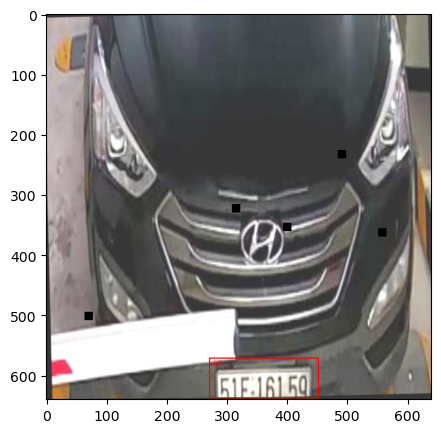

In [65]:
def yolo_xywhn_to_xyxy(type, cx, cy, w, h, W, H):
    print(type)
    # centre/largeur/hauteur normalisés -> coins en pixels
    x = cx * W
    y = cy * H
    bw = w * W
    bh = h * H
    xmin = x - bw/2
    ymin = y - bh/2
    xmax = x + bw/2
    ymax = y + bh/2
    # clamp dans l'image
    return torch.tensor([
        max(0, xmin), max(0, ymin),
        min(W-1, xmax), min(H-1, ymax)
    ], dtype=torch.float32)

C, H, W = img.shape

boxes_xyxy = torch.stack([yolo_xywhn_to_xyxy(*b, W, H) for b in label], dim=0)  # [N,4]

# draw_bounding_boxes attend uint8 et coords en pixels
img_with_boxes = draw_bounding_boxes(
    image=(img*255.0).to(torch.uint8),
    boxes=boxes_xyxy,
    labels=[f"obj{i}" for i in range(len(label))],  # optionnel
    colors="red",  # optionnel
    width=2
)
fig = plt.figure(figsize=(8, 5))
plt.imshow(img_with_boxes.permute(1, 2, 0))

# Model finetuning

In [25]:
import random

# Generate a random integer between 1 and 10 (inclusive)

def filtre(val, file):
    test = []
    i=0
    while (i<val):
        random_integer = random.randint(1, len(file))
        if random_integer not in test:
            test.append(random_integer)
            i+=1
    return test


In [26]:
train_selected = filtre(10500, train_filenames)
validation_selected = filtre(1023, validation_filenames)
test_selected = filtre(510, test_filenames)

In [36]:
import shutil
def transfert(selected, filenames, subfile1, subfile2):
    for i in range (len(selected)):
        shutil.copy(path+subfile1+filenames[i], path[:-1]+"2/"+subfile1)
        shutil.copy(path+subfile2+filenames[i][:-3]+"txt", path[:-1]+"2/"+subfile2)

transfert(train_selected, train_filenames, "train/images/", "train/labels/")
transfert(test_selected, test_filenames, "test/images/", "test/labels/")
transfert(validation_selected, validation_filenames, "valid/images/", "valid/labels/")

In [322]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
metrics = model.val(data=path+'data.yaml',  imgsz=640, batch=16)

Ultralytics 8.3.228 🚀 Python-3.9.16 torch-1.13.1 CPU (Apple M2)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 183.3±65.3 MB/s, size: 41.4 KB)
val: Scanning /Users/mamoudousdiani/Documents/projet_AI-SE/DATA/License_Plate_Recognition2/valid/labels.cache... 1023 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1023/1023 905.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 64/64 5.0s/it 5:203.9ss
                   all       1023       1060   0.000728     0.0142   0.000373   0.000183
                person       1021       1060   0.000728     0.0142   0.000373   0.000183
Speed: 1.0ms preprocess, 303.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /Users/mamoudousdiani/Documents/projet_AI-SE/CODE/Car_identification-OCR/AI/runs/detect/val9



0: 640x640 3 cars, 2840.5ms
Speed: 16.9ms preprocess, 2840.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


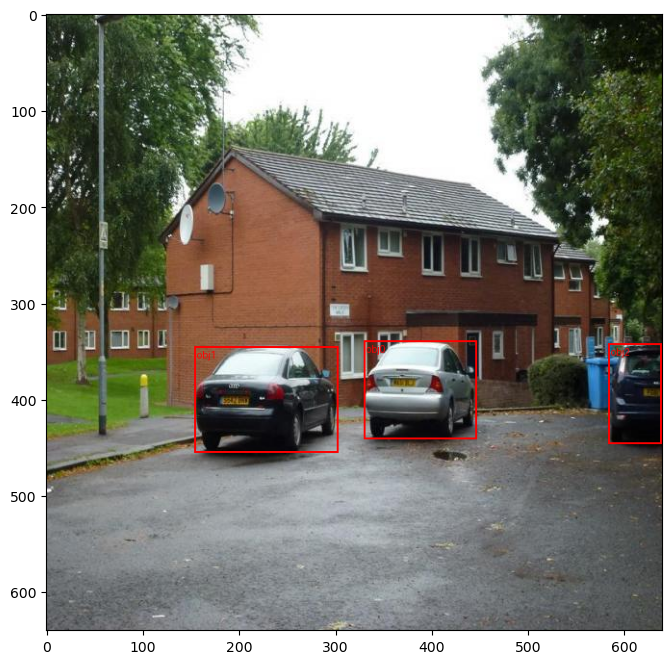

In [323]:
img_val = read_image(path+"valid/images/00cac7ea145fc734_jpg.rf.e4a2c9c33901868680f81a29bfb49b72.jpg")
result = model([path+"valid/images/00cac7ea145fc734_jpg.rf.e4a2c9c33901868680f81a29bfb49b72.jpg"])  # return a list of Results objects
boxe = result[0].boxes.xyxy  
C, H, W = [3, 640, 640]

# draw_bounding_boxes attend uint8 et coords en pixels
img_with_boxes = draw_bounding_boxes(
    image=(img_val).to(torch.uint8),
    boxes=boxe,
    labels=[f"obj{i}" for i in range(len(boxe))],  # optionnel
    colors="red",  # optionnel
    width=2
)
fig = plt.figure(figsize=(8, 8))
plt.imshow(img_with_boxes.permute(1, 2, 0))

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(data=path+'data.yaml',  # Path to YAML config
            epochs=10,                  # Number of epochs
            imgsz=640,                  # Image size
            batch=16,                   ) # Batch size

Ultralytics 8.3.228 🚀 Python-3.9.16 torch-1.13.1 CPU (Apple M2)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../../../DATA/License_Plate_Recognition2/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, ov

In [273]:
model = YOLO("yolov8n_finetune.pt")
metrics = model.val(data=path+'data.yaml',  imgsz=640, batch=16)

Ultralytics 8.3.228 🚀 Python-3.9.16 torch-1.13.1 CPU (Apple M2)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 243.7±66.2 MB/s, size: 50.9 KB)
val: Scanning /Users/mamoudousdiani/Documents/projet_AI-SE/DATA/License_Plate_Recognition2/valid/labels.cache... 1023 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1023/1023 242.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 64/64 4.8s/it 5:053.8ss
                   all       1023       1060       0.97      0.934      0.964      0.634
Speed: 1.3ms preprocess, 289.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /Users/mamoudousdiani/Documents/projet_AI-SE/CODE/Car_identification-OCR/AI/runs/detect/val5


In [274]:
metrics.results_dict

{'metrics/precision(B)': 0.9703673281125138,
 'metrics/recall(B)': 0.9339622641509434,
 'metrics/mAP50(B)': 0.9644304235161195,
 'metrics/mAP50-95(B)': 0.6339663259331153,
 'fitness': 0.6339663259331153}

In [276]:
total_params = sum(p.numel() for p in model.parameters())
print ("the total number of parameter is: ", total_params)
taille_octets = sum(p.numel() * p.element_size() for p in model.parameters())
taille_mo = taille_octets / (1024 * 1024)

print(f"Approximate model size: {taille_mo:.2f} Mo")

the total number of parameter is:  3005843
Approximate model size: 11.47 Mo


# Model testing

### Result
##### metrics/precision(B) = 0.9579
##### metrics/recall(B) = 0.91415
##### metrics/mAP50(B) = 0.95436

In [ ]:
model_finetune = YOLO("yolov8n_finetune.pt")
img_val = read_image(path+"valid/images/00cac7ea145fc734_jpg.rf.e4a2c9c33901868680f81a29bfb49b72.jpg")


0: 640x640 3 License_Plates, 1968.1ms
Speed: 15.7ms preprocess, 1968.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


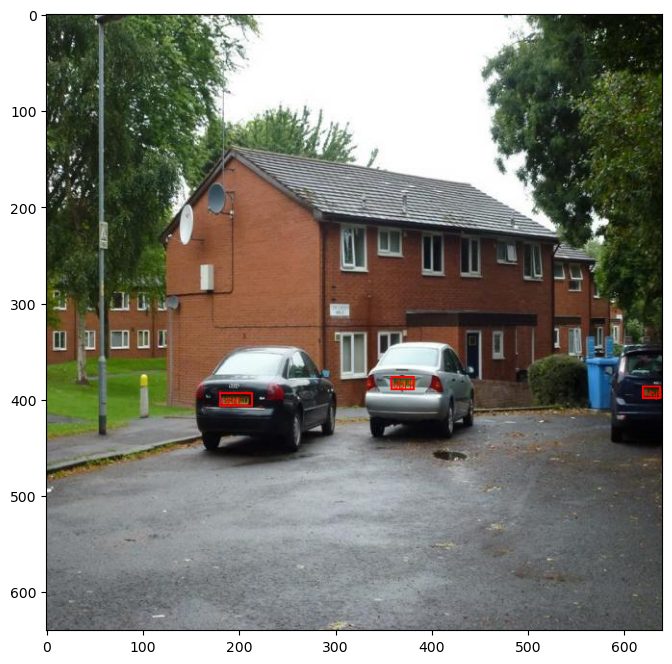

In [306]:
result = model_finetune([path+"valid/images/00cac7ea145fc734_jpg.rf.e4a2c9c33901868680f81a29bfb49b72.jpg"])  # return a list of Results objects
boxe = result[0].boxes.xyxy  
C, H, W = [3, 640, 640]

# draw_bounding_boxes attend uint8 et coords en pixels
img_with_boxes = draw_bounding_boxes(
    image=(img_val).to(torch.uint8),
    boxes=boxe,
    labels=[f"obj{i}" for i in range(len(boxe))],  # optionnel
    colors="red",  # optionnel
    width=2
)
fig = plt.figure(figsize=(8, 8))
plt.imshow(img_with_boxes.permute(1, 2, 0))

# Model Finetuning

In [307]:
modules_to_prune = []
for name, module in model_finetune.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        # On ajoute le module et le nom du paramètre ('weight') à la liste
        modules_to_prune.append((module, 'weight'))

In [308]:
pruning_ratio = 0.01  # Par exemple, élaguer 30% des poids

# Appliquer le pruning à tous les modules sélectionnés

for module, name in modules_to_prune:
    torch.nn.utils.prune.ln_structured(module, name=name, amount=pruning_ratio, dim=0, n=2)  # Pruning par groupes de 2 le long de la dimension 0
    torch.nn.utils.prune.remove(module, name)
model_finetune.save("yolov8n_finetune_pruned.pt")

In [324]:
model_finetune_pruned = YOLO("yolov8n_finetune_pruned.pt")

In [325]:
metrics_pr= model_finetune_pruned.val(data=path+'data.yaml',  imgsz=640, batch=16)

Ultralytics 8.3.228 🚀 Python-3.9.16 torch-1.13.1 CPU (Apple M2)
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 94.7±64.5 MB/s, size: 40.9 KB)
val: Scanning /Users/mamoudousdiani/Documents/projet_AI-SE/DATA/License_Plate_Recognition2/valid/labels.cache... 1023 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1023/1023 1.7Mit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 64/64 5.7s/it 6:034.9ss
                   all       1023       1060      0.975      0.927      0.957      0.597
Speed: 1.5ms preprocess, 343.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /Users/mamoudousdiani/Documents/projet_AI-SE/CODE/Car_identification-OCR/AI/runs/detect/val10


In [326]:
metrics_pr.results_dict

{'metrics/precision(B)': 0.9753046297410111,
 'metrics/recall(B)': 0.9273584905660377,
 'metrics/mAP50(B)': 0.957360522386204,
 'metrics/mAP50-95(B)': 0.5970544567208591,
 'fitness': 0.5970544567208591}


0: 640x640 1 License_Plate, 3184.0ms
Speed: 11.0ms preprocess, 3184.0ms inference, 10.8ms postprocess per image at shape (1, 3, 640, 640)


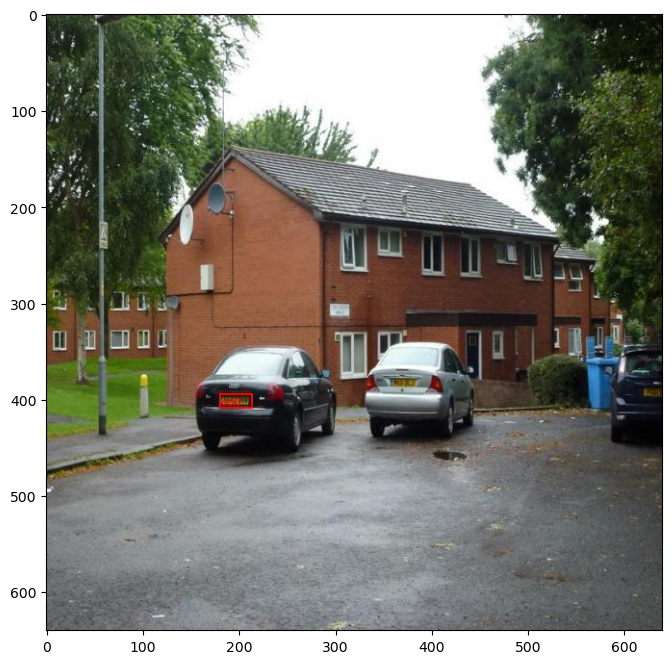

In [312]:
path_img = "valid/images/00cac7ea145fc734_jpg.rf.e4a2c9c33901868680f81a29bfb49b72.jpg"
result = model_finetune_pruned([path+path_img])  # return a list of Results objects
img_val = read_image(path+path_img)
boxe = result[0].boxes.xyxy  
C, H, W = [3, 640, 640]

# draw_bounding_boxes attend uint8 et coords en pixels
img_with_boxes = draw_bounding_boxes(
    image=(img_val).to(torch.uint8),
    boxes=boxe,
    labels=[f"obj{i}" for i in range(len(boxe))],  # optionnel
    colors="red",  # optionnel
    width=2
)
fig = plt.figure(figsize=(8, 8))
plt.imshow(img_with_boxes.permute(1, 2, 0))

In [313]:
total_params = sum(p.numel() for p in model_finetune_pruned.parameters())
print ("the total number of parameter is: ", total_params)
taille_octets = sum(p.numel() * p.element_size() for p in model_finetune_pruned.parameters())
taille_mo = taille_octets / (1024 * 1024)

print(f"Approximate model size: {taille_mo:.2f} Mo")

the total number of parameter is:  3005843
Approximate model size: 11.47 Mo


# Model exportation to onnx

In [314]:
model = YOLO("yolov8n_finetune_pruned.pt")

# Export to TFLite format with INT8 quantization
# The 'data' argument provides calibration images
model.export(format="onnx")


Ultralytics 8.3.228 🚀 Python-3.9.16 torch-1.13.1 CPU (Apple M2)

PyTorch: starting from 'yolov8n_finetune_pruned.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (29.1 MB)

ONNX: starting export with onnx 1.19.1 opset 17...
ONNX: slimming with onnxslim 0.1.80...
ONNX: export success ✅ 4.0s, saved as 'yolov8n_finetune_pruned.onnx' (11.7 MB)

Export complete (7.9s)
Results saved to /Users/mamoudousdiani/Documents/projet_AI-SE/CODE/Car_identification-OCR/AI
Predict:         yolo predict task=detect model=yolov8n_finetune_pruned.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n_finetune_pruned.onnx imgsz=640 data=../../../DATA/License_Plate_Recognition2/data.yaml  
Visualize:       https://netron.app


'yolov8n_finetune_pruned.onnx'

In [315]:
model_onnx = YOLO("yolov8n_finetune_pruned.onnx")

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [316]:
metrics_onnx = model_onnx.val(data=path+'data.yaml',  imgsz=640, batch=16)

Ultralytics 8.3.228 🚀 Python-3.9.16 torch-1.13.1 CPU (Apple M2)
Loading yolov8n_finetune_pruned.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.19.2 CPUExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 186.8±35.4 MB/s, size: 36.8 KB)
val: Scanning /Users/mamoudousdiani/Documents/projet_AI-SE/DATA/License_Plate_Recognition2/valid/labels.cache... 1023 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1023/1023 1.6Mit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1023/1023 8.3it/s 2:04<0.1s
                   all       1023       1060      0.973      0.926      0.955      0.597
Speed: 0.6ms preprocess, 109.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /Users/mamoudousdiani/Documents/projet_AI-SE/CODE/Car_identification-OCR/AI/runs/detect/val8


In [317]:
metrics_onnx.results_dict

{'metrics/precision(B)': 0.9725301612701747,
 'metrics/recall(B)': 0.9264150943396227,
 'metrics/mAP50(B)': 0.9553517961161511,
 'metrics/mAP50-95(B)': 0.5968446151702953,
 'fitness': 0.5968446151702953}


0: 640x640 1 License_Plate, 120.7ms
Speed: 34.8ms preprocess, 120.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


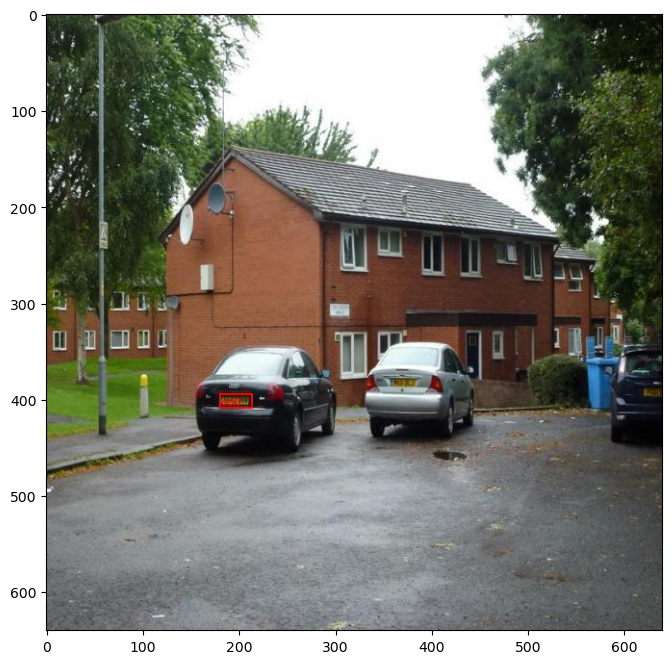

In [320]:
path_img = "valid/images/00cac7ea145fc734_jpg.rf.e4a2c9c33901868680f81a29bfb49b72.jpg"
result = model_onnx([path+path_img])  # return a list of Results objects
img_val = read_image(path+path_img)
boxe = result[0].boxes.xyxy  
C, H, W = [3, 640, 640]

# draw_bounding_boxes attend uint8 et coords en pixels
img_with_boxes = draw_bounding_boxes(
    image=(img_val).to(torch.uint8),
    boxes=boxe,
    labels=[f"obj{i}" for i in range(len(boxe))],  # optionnel
    colors="red",  # optionnel
    width=2
)
fig = plt.figure(figsize=(8, 8))
plt.imshow(img_with_boxes.permute(1, 2, 0))

# Model optimization for edge device (executorch)

- 1 - Créez une instance de la classe XnnpackQuantizer. Définissez ensuite les paramètres de quantification (comme le choix entre symétrique ou asymétrique).
- 2 - Utilisez torch.export.export pour préparer le modèle à la quantification (génération du graphe statique).
- 3 - Appelez prepare_pt2e pour préparer le modèle à la quantification (insertion des "observateurs" dans le graphe).
- 4 - Pour la quantification statique, exécutez le modèle préparé avec des échantillons de données représentatifs afin de calibrer les plages d'activation des tenseurs quantifiés.
- 5 - Appelez convert_pt2e pour convertir réellement le modèle en format quantifié (Int8).
- 6 - Exportez et "abaissez" (lower) le modèle en utilisant le flux standard vers le format .pte.

In [83]:
from ultralytics import YOLO
import torch
import os
from torchvision import transforms
from PIL import Image
from executorch.backends.xnnpack.quantizer.xnnpack_quantizer import XNNPACKQuantizer, get_symmetric_quantization_config
from torchao.quantization.pt2e.quantize_pt2e import convert_pt2e, prepare_pt2e
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
from executorch.exir import to_edge_transform_and_lower

In [77]:
model = YOLO("yolov8n_finetune_pruned.pt")
model = model.model.eval()

In [60]:
path = "../../../DATA/License_Plate_Recognition2/"

sample_inputs_filename = [name for name in os.listdir(path + "train/images/")][:500]
calibration_sample = []
for i in range (len (sample_inputs_filename)):
    image = Image.open(path + "train/images/" + sample_inputs_filename[i]).convert('RGB')
    transform = transforms.Compose([transforms.ToTensor()])
    calibration_sample.append(transform(image).unsqueeze(0))

sample_input = (calibration_sample[0],)

- get_symmetric_quantization_config(is_per_channel=True) ==> utilitaire qui génère une configuration de base pour transformer un modèle Float32 en un modèle quantifié. le symetrique permet de faire correspondre les valeurs reel flotant a des entiers (qmin = -127 and qmax = 127). is_per_channel = True ==> Les poids sont quantifiés entre les canaux

- XNNPACKQuantizer() ==> permet de quantifier les modèles afin d'exploiter les opérateurs de quantification offerts par la bibliothèque XNNPACK ==> est la solution ExecuTorch pour l'exécution sur les processeurs mobiles

- torch.export.export() prend un torch.nn.Module et produit un graphe tracé représentant uniquement le calcul Tensor de la fonction de manière Ahead-of-Time (AOT)

- prepare_pt2e permet de transformer un modèle "propre" en un modèle "instrumenté" capable d'apprendre comment se comporter une fois compressé.

- prepared_model "apprend" au model comment il va devoir se comporter une fois qu'il sera compressé en Int8.

In [78]:
# (1)
qparams = get_symmetric_quantization_config(is_per_channel=True)
quantizer = XNNPACKQuantizer()
quantizer.set_global(qparams)

In [79]:
# (2)
training_ep = torch.export.export(model, sample_input).module()


In [80]:
# (3)
prepared_model = prepare_pt2e(training_ep, quantizer)

In [ ]:
# (4)
for cal_sample in calibration_sample: 
	prepared_model(cal_sample) 

In [82]:
# (5)
quantized_model = convert_pt2e(prepared_model)

In [84]:
# (6)
et_program = to_edge_transform_and_lower(
    torch.export.export(quantized_model, sample_input),
    partitioner=[XnnpackPartitioner()],
).to_executorch()

In [87]:
with open("model_quantified_executorch.pte", "wb") as f:
    f.write(et_program.buffer)